# Cancer Detection Mini-Project

Zhen Lian

## Overview
The goal of this project is to develop a image classifier which detects histopathologic cancer from microscope images of patients' cells using convolutional neural network. The dataset used in this work is from this Kaggle challenge: https://www.kaggle.com/c/histopathologic-cancer-detection. Link to GitHub repository: https://github.com/zlianrpi/CNN-cancer-detection-mini-project.git

## Exploratory data analysis

First let us check the dimensionality of the image data by randomly loading some images and display their dimensions.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import glob, time
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import KFold, train_test_split

In [2]:
image_list = glob.glob('.\\train\\*.tif')
n_image = len(image_list)
n_image

220025

(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)


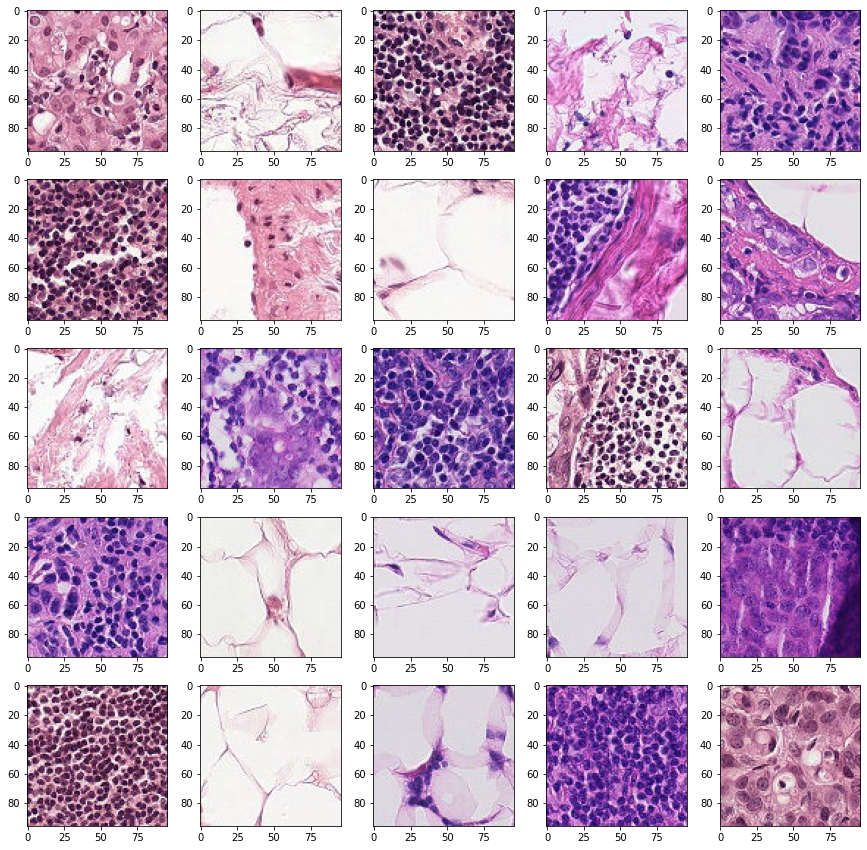

In [3]:
random_indexes = np.random.randint(0, n_image-1, size = 25)
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    #plt.xticks([])
    #plt.yticks([])
    #plt.grid(False)
    image = Image.open(image_list[i])
    print(np.array(image).shape)
    plt.imshow(image)
plt.show()

It shows we have 220025 images and all the images have a dimension of (96, 96, 3). This means we can directly send the images into our CNN network without cropping or resizing.

Then let us check the csv file which contains the label of each image.

In [4]:
df = pd.read_csv('train_labels.csv')
df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [5]:
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [6]:
df.isna().sum()

id       0
label    0
dtype: int64

Now we know we have 130908 non-cancer images and 89117 cancer images. None of the labels are missing, the dataset is ready to use.

We can notice that the classes in the dataset is imbalanced, with "cancer" class being the minority class. Ideally we want our classifier to catch every cancer case, so we need to train the classifier with more balanced data. Here I balanced the dataset by sampling a part of the data from "non-cancer" class: 

In [7]:
df0, df1 = df[df['label'] == 0], df[df['label'] == 1]
df0 = df0.sample(len(df1))
balanced_df = pd.concat([df0, df1])
balanced_df = balanced_df.sample(len(balanced_df))
balanced_df['label'].value_counts()

0    89117
1    89117
Name: label, dtype: int64

In [8]:
# change data format to fit input pipline
balanced_df['file_name'] = balanced_df['id'] + '.tif'
balanced_df = balanced_df.astype({'file_name': 'string', 'label': 'string' })
balanced_df

,id,label,file_name
25101,7b33d3c17beb803765e44e6661a7b8e661101195,0,7b33d3c17beb803765e44e6661a7b8e661101195.tif
65493,3716054359644fe5dad2c3d9567426400dd3832a,1,3716054359644fe5dad2c3d9567426400dd3832a.tif
133960,43295791c75f42b527c6c365aa1534e4c61bac0e,0,43295791c75f42b527c6c365aa1534e4c61bac0e.tif
42993,a06c3e4bcc5006ff47103df75b86a4f990271136,1,a06c3e4bcc5006ff47103df75b86a4f990271136.tif
172667,d44ba13be1f5d576608a2fa141ecf514ffeda6ee,0,d44ba13be1f5d576608a2fa141ecf514ffeda6ee.tif
...,...,...,...
12219,0c527c78ccf208fe073199b1d0190e58b6a3f7ad,0,0c527c78ccf208fe073199b1d0190e58b6a3f7ad.tif
91564,7a4181d47affdb37b47fae82db4b9e831731e4c0,0,7a4181d47affdb37b47fae82db4b9e831731e4c0.tif
87657,2ad697d28cf5ce736ec6817b03656c6930c9c8e7,0,2ad697d28cf5ce736ec6817b03656c6930c9c8e7.tif
45704,1710b6933e812ad546d06c5197b43deb72c0ad18,0,1710b6933e812ad546d06c5197b43deb72c0ad18.tif


Split the data into train set and test set.

In [9]:
train_df, val_df = train_test_split(balanced_df, test_size=0.2, random_state=0)

Use image generator to send the image data into tensorflow models:

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
image_gen=ImageDataGenerator()

In [12]:
train_gen = image_gen.flow_from_dataframe(dataframe=train_df,directory=".\\train\\", 
                                          x_col="file_name",y_col="label",batch_size=100,seed=0,shuffle=True,
                                          class_mode="binary",target_size=(96,96))

val_gen = image_gen.flow_from_dataframe(dataframe=val_df,directory=".\\train\\", 
                                          x_col="file_name",y_col="label",batch_size=100,seed=0,shuffle=True,
                                          class_mode="binary",target_size=(96,96))

Found 142587 validated image filenames belonging to 2 classes.
Found 35647 validated image filenames belonging to 2 classes.


## Model training and evaluation
In this part I will build three CNN models using Keras. In the first model I used three convolutional layers, each followed by a pooling layer and a batch normalization layer. Then the output of the convolutional layers is connected to a fully connected layer with 64 units.

In [13]:
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
model = tf.keras.Sequential([
  Rescaling(1./255),
  Conv2D(16, 3, activation='relu'),
  MaxPooling2D(),
  BatchNormalization(),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  BatchNormalization(),
  Conv2D(64, 3, activation='relu'),
  MaxPooling2D(),
  BatchNormalization(),
  
  Flatten(),

  Dense(64, activation='relu'),
  Dense(1, activation='sigmoid')
])

In [16]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(0.0001),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.BinaryAccuracy()])

To prevent overfitting, early stopping is applied by monitoring the binary accuracy on the validation set and terminating training when it stops increasing.

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5, restore_best_weights=True)

In [18]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks = [callback]
)

Epoch 1/100
1426/1426 [==============================] - 2880s 2s/step - loss: 0.4389 - auc: 0.8821 - binary_accuracy: 0.8018 - val_loss: 0.3892 - val_auc: 0.9068 - val_binary_accuracy: 0.8255
Epoch 2/100
1426/1426 [==============================] - 110s 77ms/step - loss: 0.3549 - auc: 0.9229 - binary_accuracy: 0.8463 - val_loss: 0.3549 - val_auc: 0.9235 - val_binary_accuracy: 0.8457
Epoch 3/100
1426/1426 [==============================] - 93s 65ms/step - loss: 0.3119 - auc: 0.9407 - binary_accuracy: 0.8672 - val_loss: 0.3403 - val_auc: 0.9290 - val_binary_accuracy: 0.8510
Epoch 4/100
1426/1426 [==============================] - 91s 64ms/step - loss: 0.2765 - auc: 0.9535 - binary_accuracy: 0.8850 - val_loss: 0.3546 - val_auc: 0.9251 - val_binary_accuracy: 0.8485
Epoch 5/100
1426/1426 [==============================] - 92s 65ms/step - loss: 0.2456 - auc: 0.9636 - binary_accuracy: 0.9006 - val_loss: 0.3301 - val_auc: 0.9355 - val_binary_accuracy: 0.8614
Epoch 6/100
1426/1426 [===========

In [20]:
model.save('model1')

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


The evaluation metrics show that model1 reached a valuation accuracy of 0.8618 and an AUC of 0.9346

In [21]:
# a function to train models
def train_model(model, name):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.0001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.BinaryAccuracy()])
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5, mode='max', restore_best_weights=True)
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=100,
        callbacks = [callback]
        )
    
    model.save(name)
    
    return model, history

Then I adjusted the model by adding two more convolutional layers.

In [22]:
model2 = tf.keras.Sequential([
    Rescaling(1./255),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(256, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
  
    Flatten(),

    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

train_model(model2, 'model2')

Epoch 1/100
1426/1426 [==============================] - 181s 127ms/step - loss: 0.3965 - auc: 0.9018 - binary_accuracy: 0.8209 - val_loss: 0.3553 - val_auc: 0.9243 - val_binary_accuracy: 0.8453
Epoch 2/100
1426/1426 [==============================] - 100s 70ms/step - loss: 0.3231 - auc: 0.9360 - binary_accuracy: 0.8615 - val_loss: 0.3603 - val_auc: 0.9220 - val_binary_accuracy: 0.8428
Epoch 3/100
1426/1426 [==============================] - 99s 70ms/step - loss: 0.2780 - auc: 0.9530 - binary_accuracy: 0.8847 - val_loss: 0.2928 - val_auc: 0.9477 - val_binary_accuracy: 0.8765
Epoch 4/100
1426/1426 [==============================] - 106s 74ms/step - loss: 0.2344 - auc: 0.9669 - binary_accuracy: 0.9058 - val_loss: 0.2928 - val_auc: 0.9498 - val_binary_accuracy: 0.8749
Epoch 5/100
1426/1426 [==============================] - 98s 68ms/step - loss: 0.1907 - auc: 0.9784 - binary_accuracy: 0.9265 - val_loss: 0.3651 - val_auc: 0.9399 - val_binary_accuracy: 0.8543
Epoch 6/100
1426/1426 [========

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


(<keras.engine.sequential.Sequential at 0x16f5774d2e0>,
 <keras.callbacks.History at 0x16f561cefd0>)

Model2 reached an accuracy of 0.8746 and an AUC of 0.9498 on the validation set, showing a marginal improvement from model1.

In the next model, I added an additional fully connected layer to the model.

In [23]:
model3 = tf.keras.Sequential([
    Rescaling(1./255),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(256, 3, activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
  
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

train_model(model3, 'model3')

Epoch 1/100
1426/1426 [==============================] - 98s 68ms/step - loss: 0.3964 - auc: 0.9017 - binary_accuracy: 0.8208 - val_loss: 0.4330 - val_auc: 0.9045 - val_binary_accuracy: 0.7998
Epoch 2/100
1426/1426 [==============================] - 98s 69ms/step - loss: 0.3150 - auc: 0.9392 - binary_accuracy: 0.8646 - val_loss: 0.3062 - val_auc: 0.9452 - val_binary_accuracy: 0.8685
Epoch 3/100
1426/1426 [==============================] - 96s 67ms/step - loss: 0.2694 - auc: 0.9558 - binary_accuracy: 0.8881 - val_loss: 0.3782 - val_auc: 0.9319 - val_binary_accuracy: 0.8495
Epoch 4/100
1426/1426 [==============================] - 102s 72ms/step - loss: 0.2301 - auc: 0.9678 - binary_accuracy: 0.9071 - val_loss: 0.3086 - val_auc: 0.9470 - val_binary_accuracy: 0.8745
Epoch 5/100
1426/1426 [==============================] - 96s 67ms/step - loss: 0.1904 - auc: 0.9780 - binary_accuracy: 0.9243 - val_loss: 0.3055 - val_auc: 0.9484 - val_binary_accuracy: 0.8765
Epoch 6/100
1426/1426 [===========

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


(<keras.engine.sequential.Sequential at 0x16f57bf23d0>,
 <keras.callbacks.History at 0x16f56218700>)

Model3 reached a accuracy of 0.8859 and an AUC of 0.9433. The improvement is marginal.

## Summary of the result

In [26]:
model.evaluate(val_gen)

357/357 [==============================] - 262s 737ms/step - loss: 0.3536 - auc: 0.9346 - binary_accuracy: 0.8618


[0.35362565517425537, 0.9345666170120239, 0.8617555499076843]

In [27]:
model2.evaluate(val_gen)

357/357 [==============================] - 19s 54ms/step - loss: 0.2928 - auc: 0.9477 - binary_accuracy: 0.8765


[0.29283395409584045, 0.9476550817489624, 0.8765113353729248]

In [28]:
model3.evaluate(val_gen)

357/357 [==============================] - 19s 54ms/step - loss: 0.4347 - auc: 0.9433 - binary_accuracy: 0.8859


[0.43468523025512695, 0.9433032870292664, 0.8858810067176819]

In [77]:
model.summary(), model2.summary(), model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, None, None, None)  0         
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, None, None, 16)   0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, None, None, 16)   64        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 32)    4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, None, None, 32)  

 max_pooling2d_14 (MaxPoolin  (None, None, None, 128)  0         
 g2D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, None, None, 128)  512       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, None, None, 256)   295168    
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, None, None, 256)  0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, None, None, 256)  1024      
 chNormalization)                                                
                                                                 
 flatten_3 (Flatten)         (None, None)              0         
          

(None, None, None)

|model name|total parameters|validation accuracy|validation AUC|
|---| ---|---|---|
|model1|433,761|0.862|0.935|
|model2|411,105|0.877|0.948|
|model3|435,809|0.886|0.943|


We see that adding more layers to the model slightly increases valication accuracy, which is a result of the model catching more features in the images. Interestingly, although model2 has less parameters compared to model1, it has higher validation accuracy. This result shows that convolutional layer followed by max pooling can efficiently reduce model size.

## Generating submission result

In [31]:
test_image_list = glob.glob('.\\test\\*.tif')
test_df = pd.DataFrame(test_image_list, columns=['file_name'])
test_df

,file_name
0,.\test\00006537328c33e284c973d7b39d340809f7271...
1,.\test\0000ec92553fda4ce39889f9226ace43cae3364...
2,.\test\00024a6dee61f12f7856b0fc6be20bc7a48ba3d...
3,.\test\000253dfaa0be9d0d100283b22284ab2f6b643f...
4,.\test\000270442cc15af719583a8172c87cd2bd9c774...
...,...
57453,.\test\fffdd1cbb1ac0800f65309f344dd15e9331e1c5...
57454,.\test\fffdf4b82ba01f9cae88b9fa45be103344d9f6e...
57455,.\test\fffec7da56b54258038b0d382b3d55010eceb9d...
57456,.\test\ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c...


In [39]:
test_gen = image_gen.flow_from_dataframe(dataframe=test_df, x_col="file_name",batch_size=100,seed=0,shuffle=False,
                                         class_mode=None, target_size=(96,96))

Found 57458 validated image filenames.


In [40]:
pred = model3.predict(test_gen)

575/575 [==============================] - 138s 240ms/step


In [59]:
y_pred = np.zeros_like(pred)
y_pred[pred>0.5] = 1
y_pred = y_pred.astype(np.int32).reshape(-1)

In [70]:
test_id = [file_name[7:-4] for file_name in test_image_list]
test_id = np.array(test_id)

In [73]:
prediction_df = pd.DataFrame(np.array([test_id, y_pred]).T, columns= ['id', 'label'])
prediction_df

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,1
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0
...,...,...
57453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,0
57454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,1
57455,fffec7da56b54258038b0d382b3d55010eceb9d7,0
57456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,1


In [74]:
prediction_df.to_csv('predictions.csv', index=False)